In [5]:
import pickle
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
os.environ['DGLBACKEND'] = 'pytorch'
from dgl import DGLGraph
import numpy as np
import scipy.sparse as spp
from scipy import spatial
from tqdm import tqdm
from dgl.data import DGLDataset
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
from ApolloScape_Dataset import ApolloScape_DGLDataset
import pytorch_lightning as pl
import wandb
from models.My_GAT import My_GAT
from models.GCN import GCN
from models.Gated_GCN import GatedGCN
from models.gnn_rnn import Model_GNN_RNN

In [6]:
train_dataset = ApolloScape_DGLDataset(train_val='train') #3447
val_dataset = ApolloScape_DGLDataset(train_val='val')  #919
test_dataset = ApolloScape_DGLDataset(train_val='test')  #230


In [7]:
# Collate function to prepare graphs
def collate_batch(samples):
    graphs, masks = map(list, zip(*samples))  # samples is a list of pairs (graph, mask) mask es VxTx1
    masks = np.vstack(masks)
    masks = torch.tensor(masks)#+torch.zeros(2)
    #masks = masks.view(masks.shape[0],-1)
    #masks= masks.view(masks.shape[0]*masks.shape[1],masks.shape[2],masks.shape[3])#.squeeze(0) para TAMAÑO FIJO
    sizes_n = [graph.number_of_nodes() for graph in graphs] # graph sizes
    snorm_n = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_n]
    snorm_n = torch.cat(snorm_n).sqrt()  # graph size normalization 
    sizes_e = [graph.number_of_edges() for graph in graphs] # nb of edges
    snorm_e = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_e]
    snorm_e = torch.cat(snorm_e).sqrt()  # graph size normalization
    batched_graph = dgl.batch(graphs)  # batch graphs
    return batched_graph, masks, snorm_n, snorm_e


dev='cuda'
batch_size=128
train_dataloader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, collate_fn=collate_batch)
val_dataloader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False,  num_workers=8, collate_fn=collate_batch)
test_dataloader=DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8, collate_fn=collate_batch)  
batched_graph, masks, snorm_n, snorm_e=next(iter(test_dataloader))
masks.shape

torch.Size([1060, 12, 1])

In [6]:
masks.sum(dim=-1).shape

torch.Size([10, 6])

In [ ]:
from sklearn.preprocessing import StandardScaler

batched_graph, masks, snorm_n, snorm_e, last_vis_obj=next(iter(test_dataloader))
print(masks.shape)
ori_data=batched_graph.ndata['x'].float()
data = ori_data.detach().clone().cpu().numpy()
print(data[:,:,0])

#new_mask = (data[:, 1:,:2]!=0) * (data[:, :-1, :2]!=0) 
#data[:, 1:,:2] = (data[:, 1:,:2] - data[:, :-1, :2]).float() * new_mask.float()
#data[:, 0, :2] = 0
'''
rescale_xy = torch.ones((1,1,2)).to(dev)
rescale_xy[:,:,0] = torch.max(abs(data[:,:,0]))
rescale_xy[:,:,1] = torch.max(abs(data[:,:,1]))
data[:,:,:2]=data[:,:,:2]/rescale_xy
print(data[0])
'''


In [ ]:
with open('../DBU_Graph/data/apollo_train_data.pkl', 'rb') as reader:
    [feat,adj, mean]=pickle.load(reader)
    
feat=np.transpose(feat, (0,3,2,1))
print(feat.shape)

In [ ]:
'''
#pruebas def preprocess_data de main.py (GRIP) 
feature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]
vel_data = feat[:,feature_id]  # N,C,T,V
vel_mask = (vel_data[:, :2, 1:]!=0) * (vel_data[:, :2, :-1]!=0) #False-> frames en los que no tenemos VELOCIDAD del obj
vel_data[:, :2, 1:] = (vel_data[:, :2, 1:] - vel_data[:, :2, :-1]).astype(float) * vel_mask.astype(float)
vel_data[:, :2, 0] = 0
print(vel_data[0,:,6:,0])
#print(new_mask[0,:,:,0])
'''


In [19]:
features=torch.from_numpy(feat[:,:70,:,:]).type(torch.float32)
#print(features.shape)

last_vis_obj_i=[]   #contains number of visible obj in each sequence of the training

for idx in range(len(adj)): 
    for i in range(len(adj[idx])): 
        if adj[idx][i,i] == 0:
            last_vis_obj_i.append(i)
            break   
            
last_vis_obj_i


torch.Size([5010, 70, 12, 11])


<IPython.core.display.Javascript object>


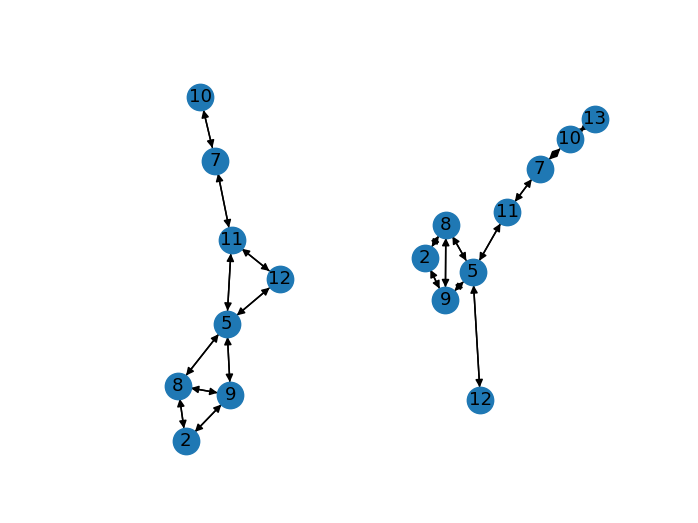

In [12]:
%matplotlib notebook

plt.subplot(1,2,1)
graph=dgl.DGLGraph(spp.coo_matrix(adj[1][:last_vis_obj[1],:last_vis_obj[1]]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.subplot(1,2,2)
graph=dgl.DGLGraph(spp.coo_matrix(adj[2][:last_vis_obj[2],:last_vis_obj[2]]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.show()

### PREPROCESS DATA

### Crear grafo (Ejemplo secuencia 0)
Para el entrenamiento iterar sobre todas las secuencias

In [293]:
now_history_frame=6
object_type = features[:,:,:,2].int()  # torch Tensor NxVxT
#vis_obj_type=np.zeros((features.shape[0],features.shape[1])) #NxV
mask_car=np.zeros((features.shape[0],features.shape[1],now_history_frame)) #NxVx6
for i in range(len(features)):
    #vis_obj_type[i,:] =object_type[i,:,5] #Append Vx1 #tipos de obj visibles de la primera seq    
    mask_car_t=np.array([1  if (j==2 or j==1) else 0 for j in object_type[i,:,5]])  #1 si obj 1/2 en frame 5 (size V)
    mask_car[i,:]=np.array(mask_car_t).reshape(mask_car.shape[1],1)+np.zeros(6) #Vx6 mask para los 6 output frames que indican si el obj es visible y car

#COMPROBADO OK
feature_id = [3, 4, 9]  #x,y,heading,[visible_mask]
#120 agentes (13 visibles -> feat[11]=1) y 12 frames (si no hay info en alguno de os 12 frames: fila nula)
node_features = features[:,:,:now_history_frame,feature_id]  #obj type,x,y 6 primeros frames
node_labels=features[:,:,now_history_frame:,3:5] #x,y 6 ultimos frames
node_features[:,:,:,-1] *= mask_car   #Pongo 0 en feat 11 [mask] a todos los obj visibles no-car
print(node_labels.shape)
node_labels[:,:,:,-1] *= mask_car
output_mask= features[:,:,6:,-1]*mask_car #mascara obj (car) visibles en 6º frame (5010,120,6)
output_mask.unsqueeze_(-1).type(torch.uint8)    #N,V,T,1                  

print(node_features.shape, node_labels.shape,output_mask.shape)
zero_indeces_list = [i for i in range(len(output_mask)) if np.all(np.array(output_mask.squeeze(-1))==0, axis=(1,2))[i] == True ]
zero_maskcar_list = [i for i in range(len(mask_car)) if np.all(np.array(mask_car)==0, axis=(1,2))[i] == True ]
#len(zero_maskcar_list) #374

total_num = len(features)
id_list = list(set(list(range(total_num))) - set(zero_indeces_list))
total_valid_num = len(id_list) #4596
ind=np.random.permutation(id_list)
train_id_list, val_id_list = ind[:round(total_valid_num*0.8)], ind[round(total_valid_num*0.8):]

print(len(train_id_list)) #3677
xy_dist=[spatial.distance.cdist(node_features[i][:,5,:], node_features[i][:,5,:]) for i in range(len(features))]  #5010x120x120

### GCN

In [ ]:
import dgl.function as fn
#Perform message passing and then apply fc Layer (self-loops! - same W for neighbors and itself)
# Traditional GCN:
#fn.copy_src(src='h', out='m')
#gcn_reduce = fn.sum(msg='m', out='h')
# multiply source node features with edge weights and aggregate them in destination nodes
gcn_msg=fn.u_mul_e('h', 'w', 'm') #elemnt-wise (broadcast)
gcn_reduce = fn.sum(msg='m', out='h')
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, dropout):
        super(GCNLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, out_feats, bias=False)
        self.linear = nn.Linear(in_feats, out_feats)
        if dropout:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = 0.
        
    def reduce_func(self, nodes):
        h = torch.sum(nodes.mailbox['m'], dim=1)
        return {'h': h}

    def forward(self, g, feature,e_w, snorm_n, snorm_e):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            
            if self.dropout:
                feature = self.dropout(feature)
            
            g.ndata['h_s']=self.linear_self(feature)
            
            #normalization
            degs = g.out_degrees().float().clamp(min=1)
            norm=torch.pow(degs,-0.5)
            shp = norm.shape + (1,)*(feature.dim() -1)
            norm = torch.reshape(norm,shp)
            feature = feature*norm
            
            #aggregate
            g.edata['w'] = e_w
            g.ndata['h'] = feature
            g.update_all(gcn_msg, self.reduce_func)
            
            #mult W and normalization
            h = self.linear(g.ndata['h'])
            degs = g.in_degrees().float().clamp(min=1)
            norm = torch.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feature.dim() - 1)
            norm = torch.reshape(norm, shp)
            h = h * norm
            
            h = g.ndata['h_s'] + h #Vx6xout_feats
            
            #h = h * (torch.ones_like(h)*snorm_n)  # normalize activation w.r.t. graph node size
            #e_w =  e_w * (torch.ones_like(e_w)*snorm_e)  # normalize activation w.r.t. graph edge size
            e_w =  e_w
            
            return h, e_w

class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, dropout):
        super().__init__()
        self.embedding_h = nn.Linear(in_feats, hid_feats)
        self.conv1 = GCNLayer(in_feats=hid_feats, out_feats=hid_feats)
        self.conv2 = GCNLayer(in_feats=hid_feats, out_feats=hid_feats)
        self.fc= nn.Linear(hid_feats,out_feats)
        self.dropout = dropout
        if dropout:
            self.linear_dropout = nn.Dropout(dropout)
        else:
            self.linear_dropout = 0.
    def forward(self, graph, inputs,e_w,snorm_n, snorm_e):
        # input embedding
        h = self.embedding_h(inputs)
        h,_ = self.conv1(graph, h,e_w,snorm_n, snorm_e,self.dropout) #Vx6x4 -> Vx6x32  
        h = F.relu(h)
        h,_ = self.conv2(graph,h,e_w,snorm_n, snorm_e,self.dropout)  #Vx6x2 
        h = F.relu(h)
        h = self.linear_dropout(h)
        y = self.fc(h)
        return y

'''
from dgl.nn import GatedGraphConv, GraphConv, GATConv,SAGEConv
conv = GraphConv(4,2, weight=True, bias=True)
#sageconv = SAGEConv(4,2,aggregator_type='lstm')
#gated_conv = GatedGraphConv(4, 2, 2, 3)
#gatconv=GATConv(4,2,num_heads=4)
graph = dgl.add_self_loop(graph)   #Añado selfloops pq no puede haber zero in-degree nodes
res = conv(graph, node_features[0])
print(res.shape)
'''    

### GAT 

In [3]:
class My_GATLayer(nn.Module):
    def __init__(self, in_feats, out_feats, feat_drop=0., attn_drop=0.):
        super(My_GATLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, out_feats, bias=False)
        self.linear_func = nn.Linear(in_feats, out_feats, bias=False)
        self.attention_func = nn.Linear(2 * out_feats, 1, bias=False)
        self.feat_drop = nn.Dropout(feat_drop)
        self.attn_drop = nn.Dropout(attn_drop)
        #self.bn_node = nn.BatchNorm1d(out_feats)
        
        self.reset_parameters()
    
    
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_self.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_func.weight, gain=gain)
        nn.init.xavier_normal_(self.attention_func.weight, gain=gain)
    
    def edge_attention(self, edges):
        concat_z = torch.cat([edges.src['z'], edges.dst['z']], dim=-1) #(n_edg,6*64)||(n_edg,6*64) -> (n_edg,2*6*64) 
        src_e = self.attention_func(concat_z)  #(n_edg, 1) att logit
        src_e = F.leaky_relu(src_e)
        return {'e': src_e}
    
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e':edges.data['e']}
        
    def reduce_func(self, nodes):
        h_s = nodes.data['h_s']
        
        #ATTN DROPOUT
        a = self.attn_drop(   F.softmax(nodes.mailbox['e'], dim=1)  )  #attention score between nodes i and j
        
        h = h_s + torch.sum(a * nodes.mailbox['z'], dim=1)
        return {'h': h}
                               
    def forward(self, g, h):
        with g.local_scope():
            
            #feat dropout
            h=self.feat_drop(h)
            
            h_in = h
            g.ndata['h']  = h 
            g.ndata['h_s'] = self.linear_self(h) 
            g.ndata['z'] = self.linear_func(h) #(18) -> (18) 
            g.apply_edges(self.edge_attention)
            g.update_all(self.message_func, self.reduce_func)
            h = g.ndata['h'] # result of graph convolution
            #h = h * snorm_n # normalize activation w.r.t. graph node size
            #h = self.bn_node(h) # batch normalization 
            
            h = torch.relu(h) # non-linear activation
            h = h_in + h # residual connection
            
            return h #graph.ndata.pop('h')


class MultiHeadGATLayer(nn.Module):
    def __init__(self, in_feats, out_feats, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(My_GATLayer(in_feats, out_feats))
        self.merge = merge

    def forward(self, g, h):
        head_outs = [attn_head(g, h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1), for intermediate layers
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average, for final layer
            return torch.mean(torch.stack(head_outs))

class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, input_dim/2) 
        self.layer2 = nn.Linear(input_dim/2, input_dim/4) 
        
    def forward(self, x):
        y = x
        y = self.layer1(y)
        y = torch.relu(y)
        y = self.layer2(y)
        return y
    
    
class My_GAT(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, dropout, feat_drop=0., attn_drop=0., heads=4):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.gat_1 = My_GATLayer(hidden_dim, hidden_dim, feat_drop, attn_drop)
        self.gat_2 = My_GATLayer(hidden_dim, hidden_dim, feat_drop, attn_drop)
        #self.gat_1 = MultiHeadGATLayer(hidden_dim, hidden_dim, heads)
        #self.gat_2 = MultiHeadGATLayer(hidden_dim*heads, hidden_dim*heads, 1)
        
        self.linear1 = nn.Linear(hidden_dim, output_dim) #hidden*heads para multihead
        #self.linear2 = nn.Linear( int(hidden_dim/2),  output_dim)
        
        if dropout:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = 0.
        
    def forward(self, g, h,e_w,snorm_n,snorm_e):
        
        # input embedding
        h = self.embedding_h(h)  #input (70, 6,4) - (70, 6,32) checked
        # gat layers
        h = self.gat_1(g, h)
        h = self.gat_2(g, h)
        
        h = self.dropout(h)
        y = self.linear1(h) 
        #y = self.linear2(torch.relu(y))
        return y
    
print( My_GAT(input_dim=24, hidden_dim=128, output_dim=12, dropout=0.1))

My_GAT(
  (embedding_h): Linear(in_features=24, out_features=128, bias=True)
  (gat_1): My_GATLayer(
    (linear_self): Linear(in_features=128, out_features=128, bias=False)
    (linear_func): Linear(in_features=128, out_features=128, bias=False)
    (attention_func): Linear(in_features=256, out_features=1, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
  )
  (gat_2): My_GATLayer(
    (linear_self): Linear(in_features=128, out_features=128, bias=False)
    (linear_func): Linear(in_features=128, out_features=128, bias=False)
    (attention_func): Linear(in_features=256, out_features=1, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
  )
  (linear1): Linear(in_features=128, out_features=12, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


### Gated GCN 
$$
\def \vx {\boldsymbol{\color{Plum}{x}}}
\def \vh {\boldsymbol{\color{YellowGreen}{h}}}
\def \ve {\boldsymbol{\color{purple}{e}}}
\def \aqua#1{\color{Aquamarine}{#1}}
\def \red#1{\color{OrangeRed}{#1}}
$$

\begin{aligned}
\vh &= \vx + \Big( A \vx +  \sum_{\aqua{v}_j \to \red{v}} \eta(\ve_{j}) \odot B \vx_j \Big)^+\\
\eta(\ve_{j}) &= \sigma(\ve_{j})\Big(\sum_{\aqua{v}_k \to \red{v}} \sigma(\ve_{k})\Big)^{-1} \\
\ve_{j} &= C \ve_{j}^{\vx} + D \vx_j + E\vx\\
\ve_{j}^{\vh} &= \ve_j^{\vx} + \Big( \ve_{j}  \Big)^+
\end{aligned}

In [ ]:
class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.A = nn.Linear(input_dim, output_dim)
        self.B = nn.Linear(input_dim, output_dim)
        self.C = nn.Linear(input_dim, output_dim)
        self.D = nn.Linear(input_dim, output_dim)
        self.E = nn.Linear(input_dim, output_dim)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    def message_func(self, edges):
        Bh_j = edges.src['Bh']
        # e_ij = Ce_ij + Dhi + Ehj   N*B,256
        e_ij = edges.data['Ce'] + edges.src['Dh'] + edges.dst['Eh']
        edges.data['e'] = e_ij
        return {'Bh_j' : Bh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        Ah_i = nodes.data['Ah']
        Bh_j = nodes.mailbox['Bh_j']
        e = nodes.mailbox['e_ij']
        # sigma_ij = sigmoid(e_ij)
        
        torch.clamp(e.sigmoid_(), min=1e-4, max=1-1e-4) 
        sigma_ij = torch.sigmoid(e)
        # hi = Ahi + sum_j eta_ij * Bhj   
        h = Ah_i + torch.sum(sigma_ij * Bh_j, dim=1) / torch.sum(sigma_ij, dim=1)  #shape n_nodes*256
        return {'h' : h}
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) 
        g.ndata['Bh'] = self.B(h) 
        g.ndata['Dh'] = self.D(h)
        g.ndata['Eh'] = self.E(h) 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e)
        
        g.update_all(self.message_func, self.reduce_func)
        
        h = g.ndata['h'] # result of graph convolution
        e = g.edata['e'] # result of graph convolution

        
        h = h * snorm_n # normalize activation w.r.t. graph node size
        e = e * snorm_e # normalize activation w.r.t. graph edge size
        
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = torch.relu(h) # non-linear activation
        e = torch.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection
        
        return h, e
    
class GatedGCN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN1 = GatedGCN_layer(hidden_dim, hidden_dim)
        self.GatedGCN2 = GatedGCN_layer(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        # graph convnet layers
        h, e = self.GatedGCN1(g, h, e, snorm_n, snorm_e)
        h, e = self.GatedGCN2(g, h, e, snorm_n, snorm_e)
        # MLP 
        y = self.linear1(h)
        
        return y

print( GatedGCN(input_dim=18, hidden_dim=64, output_dim=12))

## Pytorch Lightning Sweep

In [7]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers

class LitGNN(pl.LightningModule):
    def __init__(self, model: nn.Module = GCN, lr: float = 1e-3, batch_size: int = 64, model_type: str = 'gcn'):
        super().__init__()
        self.model= model
        self.lr = lr
        self.model_type = model_type
        self.batch_size = batch_size
        self.epoch=0
        
        self.overall_loss_train=[]
        
        self.overall_num_list=[]
        self.overall_x2y2_list=[]
        
        self.test_overall_num_list=[]
        self.test_overall_x2y2_list=[]
        
        wandb.watch(self.model, log="all")
        
    
    def forward(self, graph, feats,e_w,snorm_n,snorm_e):
        pred = self.model(graph, feats,e_w,snorm_n,snorm_e)   #inference
        return pred
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        return opt
    
    def compute_RMSE_batch(self,pred, gt, mask): 
        pred=pred.view(pred.shape[0],mask.shape[1],-1)
        pred = pred*mask #B*V,T,C  (B n grafos en el batch)
        gt = gt*mask  # outputmask BV,T,C
        x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1) # x^2+y^2 BV,T
        overall_sum_time = x2y2_error.sum(dim=-2)  #T - suma de los errores (x^2+y^2) de los V agentes
        overall_num = mask.sum(dim=-1).type(torch.int)  #torch.Tensor[(T)] - num de agentes (Y CON DATOS) en cada frame
        return overall_sum_time, overall_num, x2y2_error

    
    def training_step(self, train_batch, batch_idx):
        batched_graph, output_masks,snorm_n, snorm_e = train_batch
        feats = batched_graph.ndata['x'].float()
        #reshape to have shape (B*V,T*C) [c1,c2,...,c6]
        feats = feats.view(feats.shape[0],-1)
        e_w = batched_graph.edata['w'].float()
        if self.model_type == 'gated':
            e_w= e_w.view(e_w.shape[0],1)
        labels= batched_graph.ndata['gt'].float()
        pred = self.model(batched_graph, feats,e_w,snorm_n,snorm_e)
        overall_sum_time, overall_num, _ = self.compute_RMSE_batch(pred, labels, output_masks)  #(B,6)
        total_loss=torch.sum(overall_sum_time)/torch.sum(overall_num.sum(dim=-2))
        self.overall_loss_train.extend([total_loss.data.item()])
        #self.log('train_loss',total_loss, prog_bar=True, logger=True, on_epoch=True)
        return total_loss
    
    def training_epoch_end(self, total_loss):
        self.epoch += 1
        print('|{}| Train_loss: {}'.format(datetime.now(), np.sum(self.overall_loss_train)/len(self.overall_loss_train)))
        #self.log("Train/Loss", np.sum(self.overall_loss_train)/len(self.overall_loss_train) )
        self.logger.log_metrics({"Train/loss": np.sum(self.overall_loss_train)/len(self.overall_loss_train)}, step=self.epoch)
        #wandb.log({"Train/loss": np.sum(self.overall_loss_train)/len(self.overall_loss_train)}, step=self.epoch)#, step=epoch)      
        self.overall_loss_train=[]

    def validation_step(self, val_batch, batch_idx):
        batched_graph, output_masks,snorm_n, snorm_e = val_batch
        feats = batched_graph.ndata['x'].float()
        #reshape to have shape (B*V,T*C) [c1,c2,...,c6]
        feats = feats.view(feats.shape[0],-1)
        e_w = batched_graph.edata['w'].float()
        if self.model_type == 'gated':
            e_w= e_w.view(e_w.shape[0],1)
        labels= batched_graph.ndata['gt'].float()
        pred = self.model(batched_graph, feats,e_w,snorm_n,snorm_e)
        _, overall_num, x2y2_error = self.compute_RMSE_batch(pred, labels, output_masks)
        self.overall_num_list.extend(overall_num.detach().cpu().numpy())
        self.overall_x2y2_list.extend((x2y2_error**0.5).detach().cpu().numpy())  
        
    def validation_epoch_end(self, val_results):
        overall_sum_time=np.sum(self.overall_x2y2_list,axis=0)  #BV,T->T RMSE medio en cada T
        overall_num_time =np.sum(self.overall_num_list, axis=0)
        overall_loss_time=(overall_sum_time / overall_num_time) #media del error de cada agente en cada frame
        
        self.overall_num_list=[]
        self.overall_x2y2_list=[]
        #self.log('val/Loss',np.sum(overall_loss_time), on_step=)
        self.logger.log_metrics({'val/Loss':np.sum(overall_loss_time)}, step= self.epoch)
        #wandb.log({"Val/Loss": np.sum(overall_loss_time)}, step= self.epoch)
    
    def test_step(self, test_batch, batch_idx):
        batched_graph, output_masks,snorm_n, snorm_e = test_batch
        feats = batched_graph.ndata['x'].float()
        #reshape to have shape (B*V,T*C) [c1,c2,...,c6]
        feats = feats.view(feats.shape[0],-1)
        e_w = batched_graph.edata['w'].float()
        if self.model_type == 'gated':
            e_w= e_w.view(e_w.shape[0],1)
        labels= batched_graph.ndata['gt'].float()
        pred = self.model(batched_graph, feats,e_w,snorm_n,snorm_e)
        _, overall_num, x2y2_error = self.compute_RMSE_batch(pred, labels, output_masks)
        self.test_overall_num_list.extend(overall_num.detach().cpu().numpy())
        self.test_overall_x2y2_list.extend((x2y2_error**0.5).detach().cpu().numpy())
                  
    def test_epoch_end(self,test_results):
        overall_sum_time=np.sum(self.test_overall_x2y2_list,axis=0)  #BV,T->T RMSE medio en cada T
        overall_num_time =np.sum(self.test_overall_num_list, axis=0)
        overall_loss_time=(overall_sum_time / overall_num_time)
        self.log('test/loss', np.sum(overall_loss_time))
        #self.log('test/loss_per_sec',' '.join(['{:.3f}'.format(x) for x in list(overall_loss_time)]))
        self.log('test/loss_per_sec', overall_loss_time)    

        #wandb.log({'test/loss': np.sum(overall_loss_time)})    


def sweep_train():

    hyperparameters_default = dict (
        batch_size = batch_size,
        learning_rate = learning_rate,
        hidden_dims = hidden_dims,
        model_type = model_type,
        epochs = total_epoch
    )

    wandb.init(config= hyperparameters_default) 
    config = wandb.config
    wandb_logger = pl_loggers.WandbLogger(save_dir='./logs/')  #name=
    train_dataloader=DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=12, collate_fn=collate_batch)

    print(config.model_type)
    if config.model_type == 'gat':
        model = My_GAT(input_dim=18, hidden_dim=config.hidden_dims, output_dim=12)
    elif config.model_type == 'gcn':
        model = GCN(in_feats=18, hid_feats=config.hidden_dims, out_feats=12)
    elif config.model_type == 'gated':
        model = GatedGCN(input_dim=18, hidden_dim=config.hidden_dims, output_dim=12)

    LitGNN_sys = LitGNN(model=model, lr=config.learning_rate, model_type= config.model_type)


    trainer = pl.Trainer(gpus=1, max_epochs=20,logger=wandb_logger, check_val_every_n_epoch=3, precision=16,  profiler=True)  #precision=16, callbacks=[early_stop_callback],limit_train_batches=0.5, progress_bar_refresh_rate=20, 
    
    print("############### TRAIN ####################")
    trainer.fit(LitGNN_sys, train_dataloader, val_dataloader)   

    print("############### TEST ####################")
    trainer.test(test_dataloaders=test_dataloader)



total_epoch = 20
learning_rate =1e-3
hidden_dims=256
model_type= 'gat'

sweep_config = {
"name": "Sweep pynb",
"method": "grid",
"metric": {
  'name': 'val/Loss',
  'goal': 'minimize'   
        },
"parameters": {
        "batch_size": {
            "values": [32,64,128]
        },
        "hidden_dims": {
            "values": [64, 128, 256]
        },
        "model_type": {
            "values": ['gcn', 'gat', 'gated']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="dbu_graph")

wandb.agent(sweep_id, sweep_train)


Create sweep with ID: voe9e855
Sweep URL: https://wandb.ai/sandracl72/dbu_graph/sweeps/voe9e855


wandb: Agent Starting Run: g4tnh6lx with config:
wandb: 	batch_size: 32
wandb: 	hidden_dims: 64
wandb: 	model_type: gcn
wandb: Currently logged in as: sandracl72 (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


gcn
############### TRAIN ####################



  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 18 K  
/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


val/Loss,174.94234
_step,0
_runtime,4
_timestamp,1605797617


val/Loss,▁
_step,▁
_runtime,▁
_timestamp,▁


Run g4tnh6lx errored: DGLError('Caught DGLError in DataLoader worker process 0.\nOriginal Traceback (most recent call last):\n  File "/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop\n    data = fetcher.fetch(index)\n  File "/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch\n    return self.collate_fn(data)\n  File "<ipython-input-2-937fb2f09b21>", line 15, in collate_batch\n    return batched_graph.to(dev), masks.to(dev), snorm_n.to(dev), snorm_e.to(dev)\n  File "/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/dgl/heterograph.py", line 5005, in to\n    ret._graph = self._graph.copy_to(utils.to_dgl_context(device))\n  File "/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/dgl/heterograph_index.py", line 234, in copy_to\n    return _CAPI_DGLHeteroCopyTo(self, ctx.device_type, ctx.device_id)\n  File "dgl/_ffi/_cython/./

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


gat
############### TRAIN ####################



  | Name  | Type   | Params
---------------------------------
0 | model | My_GAT | 18 K  


val/Loss,189.18094
_step,0
_runtime,4
_timestamp,1605797628


val/Loss,▁
_step,▁
_runtime,▁
_timestamp,▁


Run 3pobvosn errored: DGLError('Caught DGLError in DataLoader worker process 0.\nOriginal Traceback (most recent call last):\n  File "/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop\n    data = fetcher.fetch(index)\n  File "/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch\n    return self.collate_fn(data)\n  File "<ipython-input-2-937fb2f09b21>", line 15, in collate_batch\n    return batched_graph.to(dev), masks.to(dev), snorm_n.to(dev), snorm_e.to(dev)\n  File "/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/dgl/heterograph.py", line 5005, in to\n    ret._graph = self._graph.copy_to(utils.to_dgl_context(device))\n  File "/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/dgl/heterograph_index.py", line 234, in copy_to\n    return _CAPI_DGLHeteroCopyTo(self, ctx.device_type, ctx.device_id)\n  File "dgl/_ffi/_cython/./

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


gated
############### TRAIN ####################


wandb: Ctrl + C detected. Stopping sweep.


## Pytorch Lightningmodel 

In [10]:

from pytorch_lightning import loggers as pl_loggers

class LitGNN(pl.LightningModule):
    def __init__(self, model: nn.Module = GCN, model_type: str = 'gat', lr: float = 1e-3, batch_size: int = 64,  wd: float = 1e-1):
        super().__init__()
        self.model= model
        self.lr = lr
        self.model_type = model_type
        self.batch_size = batch_size
        self.wd = wd
        self.overall_loss_time_list=[]
    
    def forward(self, graph, feats,e_w,snorm_n,snorm_e):
        pred = self.model(graph, feats,e_w,snorm_n,snorm_e)   #inference
        return pred
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=self.wd)
        return opt
    
    def compute_RMSE_batch(self,pred, gt, mask):
        pred = pred*mask #B*V,T,C  (B n grafos en el batch)
        gt = gt*mask  # outputmask BV,T,C
        x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1) # x^2+y^2 BV,T
        overall_sum_time = x2y2_error.sum(dim=-2)  #T - suma de los errores (x^2+y^2) de los V agentes
        overall_num = mask.sum(dim=-1).type(torch.int)  #torch.Tensor[(BV,T)] - num de agentes (Y CON DATOS) en cada frame
        return overall_sum_time, overall_num, x2y2_error

    def compute_change_pos(self, feats,gt):
        gt_vel = gt.detach().clone()
        feats_vel = feats[:,:,:2].detach().clone()
        new_mask_feats = (feats_vel[:, 1:,:2]!=0) * (feats_vel[:, :-1, :2]!=0) 
        new_mask_gt = (gt_vel[:, 1:,:2]!=0) * (gt_vel[:, :-1, :2]!=0) 

        gt_vel[:, 1:,:2] = (gt_vel[:, 1:,:2] - gt_vel[:, :-1, :2]).float() * new_mask_gt.float()
        gt_vel[:, :1, :2] = (gt_vel[:, 0:1,:2] - feats_vel[:, -1:, :2]).float()
        feats_vel[:, 1:,:2] = (feats_vel[:, 1:,:2] - feats_vel[:, :-1, :2]).float() * new_mask_feats.float()
        feats_vel[:, 0, :2] = 0
        
        return feats_vel.float(), gt_vel.float()
    
    def training_step(self, train_batch, batch_idx):
        '''needs to return a loss from a single batch'''

        batched_graph, output_masks,snorm_n, snorm_e = train_batch
        feats = batched_graph.ndata['x'].float()
        #reshape to have shape (B*V,T*C) [c1,c2,...,c6]
        feats = feats.view(feats.shape[0],-1)
        e_w = batched_graph.edata['w'].float()
        if self.model_type != 'gcn':
            e_w= e_w.view(e_w.shape[0],1)
        labels= batched_graph.ndata['gt'].float()
        pred = self.model(batched_graph, feats,e_w,snorm_n,snorm_e)
        overall_sum_time, overall_num, _ = self.compute_RMSE_batch(pred, labels, output_masks)  #(B,6)
        total_loss=torch.sum(overall_sum_time)/torch.sum(overall_num.sum(dim=-2))
        ##self.overall_loss_train.extend([total_loss.data.item()])

        # Log metrics
        self.logger.agg_and_log_metrics({"Train/loss": total_loss.data.item()}, step=self.current_epoch)
        #self.log("Train/loss",  total_loss.data.item(), on_step=False, on_epoch=True)
        return total_loss
    
    
    def validation_step(self, val_batch, batch_idx):
        batched_graph, output_masks,snorm_n, snorm_e = val_batch
        feats = batched_graph.ndata['x'].float()
        feats = feats.view(feats.shape[0],-1)
        e_w = batched_graph.edata['w'].float()
        if self.model_type != 'gcn':
            e_w= e_w.view(e_w.shape[0],1)
        labels= batched_graph.ndata['gt'].float()
        pred = self.model(batched_graph, feats,e_w,snorm_n,snorm_e)
        _, overall_num, x2y2_error = self.compute_RMSE_batch(pred, labels, output_masks)
        overall_loss_time = np.sum((x2y2_error**0.5).detach().cpu().numpy(), axis=0) / np.sum(overall_num.detach().cpu().numpy(), axis=0)#T
        self.logger.agg_and_log_metrics({'val/Loss':np.sum(overall_loss_time)}, step= self.current_epoch)
        #self.log('val/Loss', np.sum(overall_loss_time) )
        
        
    def test_step(self, test_batch, batch_idx):
        batched_graph, output_masks,snorm_n, snorm_e = test_batch
        feats = batched_graph.ndata['x'].float()
        labels= batched_graph.ndata['gt'][:,:,:2].float()
        last_loc = feats[:,-1:,:2]
        #USE CHANGE IN POS AS INPUT
        feats_vel,_ = self.compute_change_pos(feats,labels)
        #Input pos + vel
        feats = torch.cat([feats[:,:,:], feats_vel], dim=-1)

        e_w = batched_graph.edata['w'].float()
        if self.model_type != 'gcn':
            e_w= e_w.view(e_w.shape[0],1)

        pred = self.model(batched_graph, feats,e_w,snorm_n,snorm_e)
        pred=pred.view(pred.shape[0],labels.shape[1],-1)
        _, overall_num, x2y2_error = self.compute_RMSE_batch(pred, labels, output_masks[:,6:,:])
        overall_loss_time = np.sum((x2y2_error**0.5).detach().cpu().numpy(),axis=0) / np.sum(overall_num.detach().cpu().numpy(), axis=0) #T
        if np.any(np.isnan(overall_loss_time)):
            print( 'error, num: ', np.sum((x2y2_error**0.5).detach().cpu().numpy(),axis=0), np.sum(overall_num.detach().cpu().numpy(), axis=0))
            overall_loss_time[np.isnan(overall_loss_time)]=0
        print('per sec loss:{}, Sum{}'.format(overall_loss_time, np.sum(overall_loss_time)))
        self.overall_loss_time_list.append(overall_loss_time)
        #self.logger.experiment.log({ "test/loss_per_sec": overall_loss_time })
        self.log_dict({'test/loss': np.sum(overall_loss_time), "test/loss_1": torch.tensor(overall_loss_time[:2]), "test/loss_2": torch.tensor(overall_loss_time[2:4]), "test/loss_3": torch.tensor(overall_loss_time[4:]) })
 
    def on_test_epoch_end(self):
        overall_loss_time = np.array(self.overall_loss_time_list)
        avg = [sum(overall_loss_time[:,i])/overall_loss_time.shape[0] for i in range(len(overall_loss_time[0]))]
        var = [sum(abs(overall_loss_time[:,i]-avg[i]))/overall_loss_time.shape[0] for i in range(len(overall_loss_time[0]))]
        print('Loss variance: ' , var)
        
'''        
total_epoch = 20
lr =1e-3
hidden_dims=64
model_type= 'rnn'


wandb.init(project="dbu_graph", config={"epochs": total_epoch, "batch_size": batch_size, "learning_rate": lr,"model_architecture": model, "model_type":model_type "hidden_dims": hidden_dims})
config = wandb.config
wandb_logger = pl_loggers.WandbLogger(save_dir='./logs/')  #name=


if model_type == 'gat':
    model = My_GAT(input_dim=18, hidden_dim=hidden_dims, output_dim=12)
elif model_type == 'gcn':
    model = model = GCN(in_feats=18, hid_feats=hidden_dims, out_feats=12)
elif model_type == 'gated':
    model = GatedGCN(input_dim=18, hidden_dim=hidden_dims, output_dim=12)
elif model_type == 'rnn':
    model = Model_GNN_RNN()
    
#init model
LitGCN = LitGCN(model=model, model_type='gat', lr=lr)
    
# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(gpus=8) (if you have GPUs)
# using only half the training data and checking validation every quarter of a training epoch
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='max'
)
trainer = pl.Trainer(gpus=1, lr=config.learning_rate, logger=wandb_logger, max_epochs=config.epochs, progress_bar_refresh_rate=20, precision=16, profiler=True)  #val_check_interval=0.25


train_dataloader=DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=8,  collate_fn=collate_batch)
val_dataloader=DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True,  collate_fn=collate_batch)

trainer.fit(LitGCN, train_dataloader, val_dataloader)
trainer.test(test_dataloaders=test_dataloader)

!tensorboard --logdir ./lightning_logs
'''

'        \ntotal_epoch = 20\nlr =1e-3\nhidden_dims=64\nmodel_type= \'rnn\'\n\n\nwandb.init(project="dbu_graph", config={"epochs": total_epoch, "batch_size": batch_size, "learning_rate": lr,"model_architecture": model, "model_type":model_type "hidden_dims": hidden_dims})\nconfig = wandb.config\nwandb_logger = pl_loggers.WandbLogger(save_dir=\'./logs/\')  #name=\n\n\nif model_type == \'gat\':\n    model = My_GAT(input_dim=18, hidden_dim=hidden_dims, output_dim=12)\nelif model_type == \'gcn\':\n    model = model = GCN(in_feats=18, hid_feats=hidden_dims, out_feats=12)\nelif model_type == \'gated\':\n    model = GatedGCN(input_dim=18, hidden_dim=hidden_dims, output_dim=12)\nelif model_type == \'rnn\':\n    model = Model_GNN_RNN()\n    \n#init model\nLitGCN = LitGCN(model=model, model_type=\'gat\', lr=lr)\n    \n# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)\n# trainer = pl.Trainer(gpus=8) (if you have GPUs)\n# using only half the training data and c

In [21]:
a=[]  #2,3
a.append([1,1,1])
a.append([2,2,4])
a=np.array(a)
avg =[sum(a[:,i])/a.shape[0] for i in range(len(a[0]))]
print(avg)
var = [sum(abs((a[:,i]-avg[i])/a.shape[0])) for i in range(len(a[0]))]
var

[1.5, 1.5, 2.5]


[0.5, 0.5, 1.5]

In [10]:
wandb.finish()

# Train (wandb)

In [4]:
#train_iter=iter(train_dataloader)
import wandb
wandb.init(project="dbu_graph")

work_dir = './models_checkpoints'
model_type = 'gat'
hidden_dims=256
batch_train=64
batch_val=64
base_lr=1e-3
total_epoch=20

def my_save_model(model):
    path = '{}/{}_bt{}bv{}_hid{}_lr{}_ep{:03}.pt'.format(work_dir, model_type, batch_train,batch_val, hidden_dims, base_lr, total_epoch)
    if os.path.exists(path):
        path= '.' + path.split('.')[1] + '_' + str(datetime.now().minute)+ '.pt'
    torch.save(model.state_dict(), path)
    print('Successfully saved to {}'.format(path))
    
    

def compute_RMSE_batch(pred, gt, mask): 
    #output mask vale 0 si no visible o no-car o visible pero no hay datos en ese frame  (B*V,T,1), cada fila un nodo de un grafo perteneciente al batch
    pred=pred.view(pred.shape[0],mask.shape[1],-1)
    #gt=gt.view(pred.shape[0],6,-1)
    
    pred = pred*mask #B*V,T,C  (B n grafos en el batch)
    gt = gt*mask  # outputmask BV,T,C
    
    x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1) # x^2+y^2 BV,T
    overall_sum_time = x2y2_error.sum(dim=-2)  #T - suma de los errores (x^2+y^2) de los V agentes
    overall_num = mask.sum(dim=-1).type(torch.int)  #torch.Tensor[(T)] - num de agentes (Y CON DATOS) en cada frame
    return overall_sum_time, overall_num, x2y2_error


def val(model, val_dataloader,val_loss_sum):
    model.eval()
    with torch.no_grad():
        overall_num_list=[] 
        overall_x2y2_list=[]
        for batched_graph, output_masks,snorm_n, snorm_e in tqdm(val_dataloader):
            feats = batched_graph.ndata['x'].float().to(dev)
            #reshape to have shape (B*V,T*C) [c1,c2,...,c6]
            feats = feats.view(feats.shape[0],-1)
            e_w = batched_graph.edata['w'].float().to(dev)
            
            if model == 'gated':
                e_w= e_w.view(e_w.shape[0],1)
            
            labels= batched_graph.ndata['gt'].float().to(dev)
            #labels = labels.view(labels.shape[0], -1)
            pred = model(batched_graph.to(dev), feats,e_w,snorm_n,snorm_e)
            _, overall_num, x2y2_error = compute_RMSE_batch(pred, labels, output_masks.to(dev))
            #print(x2y2_error.shape)  #BV,T
            overall_num_list.extend(overall_num.detach().cpu().numpy())
            #print(overall_num.shape)  #BV,T
            overall_x2y2_list.extend((x2y2_error**0.5).detach().cpu().numpy())  #RMSE para cada nodo en cada T
            
    overall_sum_time=np.sum(overall_x2y2_list,axis=0)  #BV,T->T RMSE medio en cada T
    overall_num_time =np.sum(overall_num_list, axis=0)
    overall_loss_time=(overall_sum_time / overall_num_time) #media del error de cada agente en cada frame

    print('|{}| Val_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_time) + [np.sum(overall_loss_time)]])))
    val_loss_sum.append(np.sum(overall_loss_time))
    wandb.log({'Val/Loss': val_loss_sum[-1] }, step=epoch)
    

dev='cuda:0'
if model_type == 'gat':
    model = My_GAT(input_dim=24, hidden_dim=hidden_dims, output_dim=12, heads=4, dropout=0.25, att_ew=True).to(dev)
elif model_type == 'gcn':
    model = model = GCN(in_feats=24, hid_feats=hidden_dims, out_feats=12, dropout=0.25).to(dev)
elif model_type == 'gated':
    model = GatedGCN(input_dim=24, hidden_dim=hidden_dims, output_dim=12).to(dev)


opt = torch.optim.Adam(model.parameters(), lr=base_lr)
np.seterr(all='raise')
train_loss_sum=[]
val_loss_sum=[]
val_loss_prev=0
patience=0
wandb.watch(model, log='all')
n_epochs=0
    
for epoch in range(total_epoch):
    
    print("Epoch: ",epoch)
    overall_loss_train=[]
    model.train()
    n_epochs=epoch+1
    
    for batch_graphs, masks, batch_snorm_n, batch_snorm_e in tqdm(train_dataloader):
        feats = batch_graphs.ndata['x'].float().to(dev)
        feats=feats.view(feats.shape[0],-1)  #Nx18
        batch_e = batch_graphs.edata['w'].float().to(dev)
        #for GATED GCN
        if model_type == 'gated' or model_type == 'gat':
            batch_e=batch_e.view(batch_e.shape[0],1)
        #model = GatedGCN(input_dim=18, hidden_dim=256, output_dim=12).to(dev)
        batch_pred = model(batch_graphs.to(dev), feats, batch_e, batch_snorm_n.to(dev), batch_snorm_e.to(dev))
        #print(batch_pred.shape, masks.shape)

        labels= batch_graphs.ndata['gt'].float().to(dev)
        overall_sum_time, overall_num, _ = compute_RMSE_batch(batch_pred, labels, masks.to(dev))  #(B,6)
        total_loss=torch.sum(overall_sum_time)/torch.sum(overall_num.sum(dim=-2))
        opt.zero_grad() 
        total_loss.backward()
        #print(model.embedding_h.weight.grad) #model.GatedGCN1.A.weight.grad)
        opt.step()
        overall_loss_train.extend([total_loss.data.item()])
        
    print('|{}| Train_loss: {}'.format(datetime.now(), np.sum(overall_loss_train)/len(overall_loss_train)))
    train_loss_sum.append(np.sum(overall_loss_train)/len(overall_loss_train))
    wandb.log({"Train/loss": train_loss_sum[-1]}, step=epoch)
    
    val(model, val_dataloader, val_loss_sum)
    
    if val_loss_prev < val_loss_sum[-1] and epoch !=0:
        patience+=1
        val_loss_prev = val_loss_sum[-1]
    else:
        patience = 0
        val_loss_prev = val_loss_sum[-1]
        
    if patience > 2:
        print("Early stopping: ")
        print("Difference: {}".format(val_loss_prev-val_loss_sum[-1]))
        break
        
        
my_save_model(model)

#torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))

epochs = list(range(epoch+1))
plt.ion() #Turn the interactive mode on
plt.subplot(1,2,1)
plt.plot(epochs,train_loss_sum)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.subplot(1,2,2)
plt.plot(epochs,val_loss_sum)
plt.xlabel('Epochs')
plt.ylabel('Val Loss')
plt.show()




wandb: Currently logged in as: sandracl72 (use `wandb login --relogin` to force relogin)


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/54 [00:56<?, ?it/s]


RuntimeError: mat1 dim 1 must match mat2 dim 0

### Load Model

In [11]:

class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.A = nn.Linear(input_dim, output_dim)
        self.B = nn.Linear(input_dim, output_dim)
        self.C = nn.Linear(input_dim, output_dim)
        self.D = nn.Linear(input_dim, output_dim)
        self.E = nn.Linear(input_dim, output_dim)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    def message_func(self, edges):
        Bh_j = edges.src['Bh']
        # e_ij = Ce_ij + Dhi + Ehj   N*B,256
        e_ij = edges.data['Ce'] + edges.src['Dh'] + edges.dst['Eh']
        edges.data['e'] = e_ij
        return {'Bh_j' : Bh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        Ah_i = nodes.data['Ah']
        Bh_j = nodes.mailbox['Bh_j']
        e = nodes.mailbox['e_ij']
        # sigma_ij = sigmoid(e_ij)
        torch.clamp(e.sigmoid_(), min=1e-4, max=1-1e-4) 
        sigma_ij = torch.sigmoid(e)
        # hi = Ahi + sum_j eta_ij * Bhj   
        h = Ah_i + torch.sum(sigma_ij * Bh_j, dim=1) / torch.sum(sigma_ij, dim=1)  #shape n_nodes*256
        return {'h' : h}
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) 
        g.ndata['Bh'] = self.B(h) 
        g.ndata['Dh'] = self.D(h)
        g.ndata['Eh'] = self.E(h) 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e)
        
        g.update_all(self.message_func, self.reduce_func)
        
        h = g.ndata['h'] # result of graph convolution
        e = g.edata['e'] # result of graph convolution

        
        h = h * snorm_n # normalize activation w.r.t. graph node size
        e = e * snorm_e # normalize activation w.r.t. graph edge size
        
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = torch.relu(h) # non-linear activation
        e = torch.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection
        
        return h, e


class GatedGCN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN1 = GatedGCN_layer(hidden_dim, hidden_dim)
        self.GatedGCN2 = GatedGCN_layer(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, output_dim)
        '''
        if dropout:
            self.linear_dropout = nn.Dropout(dropout)
        else:
            self.linear_dropout =  nn.Dropout(0.)

        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.bn = bn
        '''
        
    def forward(self, g, inputs, e, snorm_n, snorm_e):

        #reshape to have shape (B*V,T*C) [c1,c2,...,c6]
        inputs = inputs.view(inputs.shape[0],-1)

        # input embedding
        h = self.embedding_h(inputs)
        e = self.embedding_e(e)
        # graph convnet layers
        h, e = self.GatedGCN1(g, h, e, snorm_n, snorm_e)
        h, e = self.GatedGCN2(g, h, e, snorm_n, snorm_e)
        # MLP 
        
        y = self.linear1(h)
        
        return y





train_dataloader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, collate_fn=collate_batch)
val_dataloader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False,  num_workers=8, collate_fn=collate_batch)
test_dataloader=DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=8, collate_fn=collate_batch)  

#gcn_model = GCN(in_feats=18, hid_feats=256, out_feats=12).to(dev)
#gat_model = My_GAT(input_dim=24, hidden_dim=511, output_dim=12,dropout=0.25, bn=False, bn_gat=False, feat_drop=False, attn_drop=False).to(dev)
#gat_model.load_state_dict(torch.load('./models_checkpoints/efficient-sweep-8.ckpt'))
#gcn_model.load_state_dict(torch.load('./models_checkpoints/gcn_256_b64_ep40_embed.pth'))
model_type='gated'
if model_type == 'gat':
    model = My_GAT(input_dim=30, hidden_dim=511, heads=1, output_dim=12,dropout=0.1, bn=False, bn_gat=False, feat_drop=0, attn_drop=0, att_ew=True)
elif model_type == 'gcn':
    model = model = GCN(in_feats=30, hid_feats=config.hidden_dims, out_feats=12, dropout=0, gcn_drop=0, bn=False, gcn_bn=False)
elif model_type == 'gated':
    model = GatedGCN(input_dim=30, hidden_dim=511, output_dim=12)

wandb.init(project='dbu_graph')
wandb_logger = pl_loggers.WandbLogger(save_dir='./logs/')
#init model
LitGCN_sys = LitGNN(model=model, lr=1e-4, model_type='gat',wd=0.1)
print(LitGCN_sys.model)
LitGCN_sys = LitGCN_sys.load_from_checkpoint(checkpoint_path='./models_checkpoints/swift-sweep-9.ckpt',model=LitGCN_sys.model)
trainer = pl.Trainer(gpus=1, profiler=True, logger= wandb_logger)

trainer.test(LitGCN_sys, test_dataloaders=test_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GatedGCN(
  (embedding_h): Linear(in_features=30, out_features=511, bias=True)
  (embedding_e): Linear(in_features=1, out_features=511, bias=True)
  (GatedGCN1): GatedGCN_layer(
    (A): Linear(in_features=511, out_features=511, bias=True)
    (B): Linear(in_features=511, out_features=511, bias=True)
    (C): Linear(in_features=511, out_features=511, bias=True)
    (D): Linear(in_features=511, out_features=511, bias=True)
    (E): Linear(in_features=511, out_features=511, bias=True)
    (bn_node_h): BatchNorm1d(511, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn_node_e): BatchNorm1d(511, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GatedGCN2): GatedGCN_layer(
    (A): Linear(in_features=511, out_features=511, bias=True)
    (B): Linear(in_features=511, out_features=511, bias=True)
    (C): Linear(in_features=511, out_features=511, bias=True)
    (D): Linear(in_features=511, out_features=511, bias=True)
    (E): Linear(in_features=511, 

/home/usuario1/miniconda3/envs/pDL/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


<ipython-input-10-85ea97de77d9>:96: RuntimeWarning: invalid value encountered in true_divide
  overall_loss_time = np.sum((x2y2_error**0.5).detach().cpu().numpy(),axis=0) / np.sum(overall_num.detach().cpu().numpy(), axis=0) #T


error, num:  [ 4.03708205  8.38758644 13.2821671   0.          0.          0.        ] [1 1 1 0 0 0]
per sec loss:[ 4.03708205  8.38758644 13.2821671   0.          0.          0.        ], Sum25.70683557847434
per sec loss:[ 2.47528645  5.40441878  8.59995356 12.13594097 15.11484074 18.55026384], Sum62.28070433510163
per sec loss:[2.67835273 2.84643324 2.78001892 2.80555377 3.28240571 3.83164474], Sum18.224409091172696
error, num:  [2.00614187 3.73621116 0.         0.         0.         0.        ] [2 2 0 0 0 0]
per sec loss:[1.00307093 1.86810558 0.         0.         0.         0.        ], Sum2.871176513300262
per sec loss:[0.2839815  0.48321658 0.12516859 0.26904194 0.26177432 0.30569796], Sum1.7288808936363824
per sec loss:[ 1.25801565  2.2018007   3.23738621  7.94127165 10.56869478  9.28642699], Sum34.49359598470592
per sec loss:[0.86736411 1.50522296 2.23961048 3.17206015 5.92418881 7.20349957], Sum20.911946076302144
per sec loss:[2.43224514 3.27404881 2.88143608 4.23605527 5.48

[{'test/loss': 20.90811538696289,
  'test/loss_1': 2.0629425772652454,
  'test/loss_2': 3.7289247454947643,
  'test/loss_3': 4.66218974150357}]

### TEST

In [10]:

xy_s1_list= []
xy_s2_list= []
xy_s3_list= []
num_s1_list= []
num_s2_list= []
num_s3_list= []

model.eval()
with torch.no_grad():
    overall_num_list=[] 
    overall_x2y2_list=[]
    for batched_graph, output_masks,snorm_n, snorm_e in tqdm(test_dataloader):
        feats = batched_graph.ndata['x'].float().to(dev)
        feats = feats.view(feats.shape[0],-1)
        e_w = batched_graph.edata['w'].float().to(dev)

        #for GatedGCN
        #e_w= e_w.view(e_w.shape[0],1)

        labels= batched_graph.ndata['gt'][:,:,:].float().to(dev)
        #labels = labels.view(labels.shape[0], -1)
        pred = model(batched_graph.to(dev), feats,e_w,snorm_n,snorm_e)
        _, overall_num, x2y2_error = compute_RMSE_batch(pred, labels, output_masks.to(dev))
        #print(x2y2_error.shape)  #BV,T
        overall_num_list.extend(overall_num.detach().cpu().numpy())
        #print(overall_num.shape)  #BV,T
        overall_x2y2_list.extend((x2y2_error**0.5).detach().cpu().numpy())  #RMSE para cada nodo en cada T

overall_sum_time=np.sum(overall_x2y2_list,axis=0)  #BV,T->T RMSE medio en cada T
overall_num_time =np.sum(overall_num_list, axis=0)
overall_loss_time=(overall_sum_time / overall_num_time) #media del error de cada agente en cada frame

print('|{}| Test_RMSE: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_time) + [np.sum(overall_loss_time)]])))


100%|██████████| 230/230 [00:10<00:00, 22.32it/s]

|2020-11-24 16:34:06.548013| Test_RMSE: 1.650 2.477 3.415 4.310 5.249 6.020 23.120
